# Proyecto 1 Etapa 2 - Inteligencia de Negocios

## Nombres
- Sara Isabel Calle.
- Carlos Enrique Silva L.
- Juliana Velasco. 

# 1. Importación de Librerias

In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns 
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import re, string, unicodedata
from keras.preprocessing.text import Tokenizer 
from scipy.sparse import hstack

#Importacions sklearn
from sklearn import tree as tr
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from mlxtend.feature_selection import ColumnSelector


# Librerías de nltk que serán utilizadas.
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

# Preprocesamiento de texto.
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

#Modulos propios para modificar los datos
from PrepData import *

# Importar/ Exportar modelos
from joblib import dump, load


Bad key text.latex.preview in file C:\Users\cesl\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\cesl\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\cesl\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You probably

## 2. Carga y entendimiento de los datos

In [3]:
#Cargar datos al dataframe
df_elegibilidad = pd.read_csv('clinical_trials_on_cancer_data_clasificacion.csv', sep=',', encoding = 'utf-8', na_values = '')

In [4]:
#Ver parte de los datos
df_elegibilidad.head()

,label,study_and_condition
0,__label__0,study interventions are Saracatinib . recurren...
1,__label__1,study interventions are Stem cell transplantat...
2,__label__0,study interventions are Lenograstim . recurren...
3,__label__0,study interventions are Doxorubicin . stage ii...
4,__label__1,study interventions are Poly I-C . prostate ca...


## 3. Random Forest 

### Preprocesamiento

In [5]:
#Separar la columna study_and_condition en 2 (study, condition)
df_temp = df_elegibilidad['study_and_condition'].str.split('.', expand=True)
df_temp.head()

,0,1,2,3
0,study interventions are Saracatinib,recurrent verrucous carcinoma of the larynx d...,None,None
1,study interventions are Stem cell transplantat...,hodgkin lymphoma diagnosis and history of con...,None,None
2,study interventions are Lenograstim,recurrent adult diffuse mixed cell lymphoma d...,None,None
3,study interventions are Doxorubicin,stage iii diffuse large cell lymphoma diagnos...,None,None
4,study interventions are Poly I-C,prostate cancer diagnosis and unresolved irae...,None,None


In [6]:
#Las columnas 2 y 3 se generaron por puntos puestos o espacios, se juntan entonces las columnas 1,2,3 en una sola
df_temp.fillna(" ", inplace = True)
df_temp['label'] = df_elegibilidad['label']
df_temp['study'] = df_temp[0]
df_temp['condition'] = df_temp[1] + df_temp[2] + df_temp[3]
df_elegibilidad = df_temp.drop([0, 1, 2, 3], axis=1)
df_elegibilidad.head()

,label,study,condition
0,__label__0,study interventions are Saracatinib,recurrent verrucous carcinoma of the larynx d...
1,__label__1,study interventions are Stem cell transplantat...,hodgkin lymphoma diagnosis and history of con...
2,__label__0,study interventions are Lenograstim,recurrent adult diffuse mixed cell lymphoma d...
3,__label__0,study interventions are Doxorubicin,stage iii diffuse large cell lymphoma diagnos...
4,__label__1,study interventions are Poly I-C,prostate cancer diagnosis and unresolved irae...


In [7]:
#Eliminar duplicados
df_elegibilidad = df_elegibilidad.drop_duplicates()

In [8]:
#Ver tamanio del Df
df_elegibilidad.shape

(11988, 3)

In [9]:
#Realizar una copia del df
df_model=df_elegibilidad.copy()

In [10]:
#Pasar labels a numerico para que el modelo funcione
df_model['label'] = df_model.label.replace('__label__0', 0)
df_model['label'] = df_model.label.replace('__label__1', 1)
df_model.head()

,label,study,condition
0,0,study interventions are Saracatinib,recurrent verrucous carcinoma of the larynx d...
1,1,study interventions are Stem cell transplantat...,hodgkin lymphoma diagnosis and history of con...
2,0,study interventions are Lenograstim,recurrent adult diffuse mixed cell lymphoma d...
3,0,study interventions are Doxorubicin,stage iii diffuse large cell lymphoma diagnos...
4,1,study interventions are Poly I-C,prostate cancer diagnosis and unresolved irae...


In [11]:
vectorizer1 = TfidfVectorizer()  
vectorizer2 = TfidfVectorizer()  
ct=make_column_transformer((vectorizer1,0),(vectorizer2,1))

In [12]:
#Crear un preprocesador para realizar procesamiento de lenguaje natural
out_study = FunctionTransformer(column_preprocessing, validate = False)
out_condition = FunctionTransformer(column_preprocessing, validate = False)
t = [
    ('study_Tr', out_study, ['study']),
    ('condition_Tr', out_condition, ['condition']),
]
data_preprocessor = ColumnTransformer(transformers=t,  remainder='drop', sparse_threshold=0)

In [13]:
#Preprocesamiento
pre = [('data_preprocessing', data_preprocessor)]

In [14]:
#Model
model = [('model', RandomForestClassifier(n_estimators=80,  criterion='entropy', max_depth=500))]

In [15]:
#Declara el pipeline 
pipeline = Pipeline(steps=[('data_preprocessing', data_preprocessor), ('vectorizing', ct),('model', RandomForestClassifier(n_estimators=80,  criterion='entropy', max_depth=500))])

In [16]:
#Extraemos las variables explicativas y objetivo para entrenar
X = df_model.drop('label', axis = 1)
Y = df_model['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=100)

In [17]:
#Entrenar el modelo
pipeline = pipeline.fit(X_train,Y_train)

In [18]:
# Determinamos las predicciones del modelo sobre el conjunto test.
y_pred = pipeline.predict(X_test)

In [19]:
# Se genera la matriz de confusión
confusion_matrix(Y_test, y_pred)

array([[975, 259],
       [205, 959]], dtype=int64)

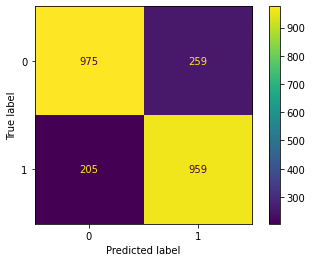

In [20]:
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(pipeline, X_test, Y_test)  
plt.show() 

In [21]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1234
           1       0.79      0.82      0.81      1164

    accuracy                           0.81      2398
   macro avg       0.81      0.81      0.81      2398
weighted avg       0.81      0.81      0.81      2398



# 7. Exportar el modelo

In [22]:
#Usamos la lbreria joblib
filename = 'modelo.joblib'
#Se guarda
dump(pipeline, filename) 

['modelo.joblib']

In [23]:
X_test

,study,condition
211,study interventions are Everolimus,recurrent renal cell cancer diagnosis and adu...
1302,study interventions are Bevacizumab,fallopian tube cancer diagnosis and hepatic f...
2202,study interventions are Oxaliplatin,gastric cancer diagnosis and patients must ha...
57,study interventions are Melphalan,iii ii with symptomatic bone lesion radiologi...
689,study interventions are Mycophenolic Acid,childhood diffuse large cell lymphoma diagnos...
...,...,...
2344,study interventions are Lenograstim,recurrent adult diffuse small cleaved cell ly...
2371,study interventions are Mogamulizumab,solid tumor diagnosis and subject who has und...
7946,study interventions are Interferon-gamma,osteosarcoma diagnosis and aspartate transami...
8438,study interventions are Vadimezan,metastatic cancer with impaired renal functio...


In [24]:
data = [['study interventions are Stem cell transplantation','hodgkin lymphoma diagnosis and history of congenital hematologic immunologic or metabolic disorder which in the estimation of the pi poses prohibitive risk to the recipient']]
df_test = pd.DataFrame(data, columns = ['study', 'condition'])
df_test

,study,condition
0,study interventions are Stem cell transplantation,hodgkin lymphoma diagnosis and history of cong...


In [25]:
x = pipeline.predict(df_test)
print(x[0])

1
